# Springed pendulum

In this notebook, we will solve the springed pendulum system. 

![Springed pendulum](https://ths.rwth-aachen.de/wp-content/uploads/sites/4/research/HyPro/pics/spring_pendulum.png)


## System description

The springed pendulum is a system composed of a mass $m$ attached to a spring of $k$ constant and a pendulum of length $l$. The system is subject to gravity $g$ and a friction force $b$. 

## Necessary imports

We will use the following libraries:

* `numpy` for numerical computations
* `matplotlib` for plotting
* `scipy.integrate` for solving the system of differential equations
* `sympy` for symbolic computations

### Installations (if needed)

In [2]:
%pip install numpy matplotlib scipy sympy --quiet

Note: you may need to restart the kernel to use updated packages.


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import odeint
import sympy as sym

## Definitions

We start by defining the system parameters:

* $m$ : mass (constant)
* $k$ : spring constant
* $g$ : gravity
* $b$ : friction coefficient (constant)
* $\\l_0$ : spring rest length (constant)
* $t$ : time (variable)
* $l$ : pendulum length as function of time (because it is a spring)
* $\theta$ : pendulum angle as a function of time (with respect to the vertical axis)

In [2]:
# Constants
m, k, g, l0 = sym.symbols('m k g l_0', real=True, positive=True)

# Variables
t = sym.symbols('t')

# Functions variables
l, theta = sym.Function('l')(t), sym.Function('\\theta')(t)

## Getting the equations of motion

We will use the Lagrangian formalism to get the equations of motion.

We start by defining the Lagrangian:

$$L = T - V$$

where $T$ is the kinetic energy and $V$ is the potential energy. So we need to define the kinetic energy and the potential energy.

* Kinetic energy: $T = \displaystyle\frac{1}{2} m v^2$
* Potential energy: $V = \underbrace{m g h}_{\text{gravitational potential energy}} + \underbrace{\frac{1}{2} k (l - l_0)^2}_{\text{elastic potential energy}}$

where $h$ is the height of the mass above the ground, $l_0$ is the initial length of the spring and $v$ is the speed of the mass.

$$v = \displaystyle\frac{d}{dt} \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} \dot{x} \\ \dot{y} \end{pmatrix}$$

and in our system:

$$x = l \sin(\theta)\qquad y = -l \cos(\theta)$$

In [3]:
# Cartesian coordinates
x = l * sym.sin(theta)
y = -l * sym.cos(theta)

# Kinetic energy
T = (1/2) * m * (x.diff(t)**2 + y.diff(t)**2)

# Potential gravitational energy
Vg = m * g * y

# Potential elastic energy
Vk = (1/2) * k * (l - l0)**2

# Potential energy
V = Vg + Vk

# Lagrangian
L = T - V

In [4]:
L

g*m*l(t)*cos(\theta(t)) - 0.5*k*(-l_0 + l(t))**2 + 0.5*m*((l(t)*sin(\theta(t))*Derivative(\theta(t), t) - cos(\theta(t))*Derivative(l(t), t))**2 + (l(t)*cos(\theta(t))*Derivative(\theta(t), t) + sin(\theta(t))*Derivative(l(t), t))**2)

At this point, we can obtain the Euler-Lagrange equations of motion:

$$\frac{d}{dt} \frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = 0$$

where $q$ is the vector of generalized coordinates and $\dot{q}$ is the vector of their time derivatives. Since we have 2 generalized coordinates, we have 2 equations of motion, one for $\theta$ and one for $l$.

In [5]:
# Equation for theta
LEtheta = (sym.diff(sym.diff(L, theta.diff(t)), t) - L.diff(theta)).simplify()
LEtheta

m*(g*sin(\theta(t)) + l(t)*Derivative(\theta(t), (t, 2)) + 2*Derivative(\theta(t), t)*Derivative(l(t), t))*l(t)

In [6]:
# Equation for l
LEl = (sym.diff(sym.diff(L, l.diff(t)), t) - L.diff(l)).simplify()
LEl

-1.0*g*m*cos(\theta(t)) - 1.0*k*l_0 + 1.0*k*l(t) - 1.0*m*l(t)*Derivative(\theta(t), t)**2 + 1.0*m*Derivative(l(t), (t, 2))

Now we can solve the equations of motion for $\ddot{\theta}$ and $\ddot{l}$:

In [7]:
sols = sym.solve([LEtheta, LEl], [theta.diff(t, 2), l.diff(t, 2)], simplify=False)

Let's check the results:

In [8]:
# ddot_theta
sym.Eq(theta.diff(t, 2), sols[theta.diff(t, 2)])
# sols[theta.diff(t, 2)].simplify()

Eq(Derivative(\theta(t), (t, 2)), -g*sin(\theta(t))/l(t) - 2.0*Derivative(\theta(t), t)*Derivative(l(t), t)/l(t))

In [9]:
# ddot_l
sym.Eq(l.diff(t, 2), sols[l.diff(t, 2)])

Eq(Derivative(l(t), (t, 2)), g*cos(\theta(t)) + k*l_0/m - k*l(t)/m + l(t)*Derivative(\theta(t), t)**2)

At this moment we have second order differential equations.
$$ \ddot{\theta} = ....$$
$$ \ddot{l} = ....$$

to solve them we need to convert them to first order differential equations. We can do this by introducing two new variables: 

$$\dot{\theta} = \omega$$
$$\dot{l} = z$$

so, now we have 4 first order differential equations:

$$\dot{\omega} = \cdots$$
$$\dot{z} = \cdots$$
$$\dot{\theta} = \omega$$
$$\dot{l} = z$$

**Note:** When we write a variable with a dot, we mean the time derivative of that variable.

Now, we need to convert the **symbolic** expressions to **numeric** expressions. We do this by using the `lambdify` function from the `SymPy` library. This function takes a symbolic expression and returns a function that can be evaluated numerically.

In [10]:
omega_dot = sym.lambdify((t, m, k, g, l0, l, theta, theta.diff(t), l.diff(t)), sols[theta.diff(t, 2)])
z_dot = sym.lambdify((t, m, k, g, l0, l, theta, theta.diff(t), l.diff(t)), sols[l.diff(t, 2)])
omegaf = sym.lambdify(theta.diff(t), theta.diff(t))
zf = sym.lambdify(l.diff(t), l.diff(t))

We can try this function by evaluating with some values:

In [11]:
omega_dot(0.5, 1, 0.2, 9.81, 0.1, 1, 1.2, np.pi/2, 0)

-9.14330343333849

To make the code more readable, we will define a function that takes the parameters and the initial conditions and returns the equations of motion:
$$\frac{d\vec{S}}{dt}(\vec{S}) = \begin{pmatrix} \dot{\theta} \\ \dot{\omega} \\ \dot{l} \\ \dot{z} \end{pmatrix} \qquad \vec{S} = \begin{pmatrix} \theta \\ \omega \\ l \\ z \end{pmatrix}$$

In [12]:
def dSdt(S, t, m, k, g, l0):
    theta, omega, l, z = S
    return [omegaf(omega),
            omega_dot(t, m, k, g, l0, l, theta, omega, z),
            zf(z),
            z_dot(t, m, k, g, l0, l, theta, omega, z),]

We can now solve the system. We will use the `odeint` function from the `scipy.integrate` library. This function takes a function that returns the derivatives of the state vector and the initial state vector and returns the state vector at each time step. But we need to define the system parameters and the initial conditions first.

* $m = 1$ kg
* $k = 10$ N/m
* $g = 9.81 \text{ m/s}^2$
* $b = 0.1$ Ns/m
* $l_0 = 1$ m (initial length of the spring)
* $\theta_0 = 0.5$ rad 
* $l_{00} = 1.2$ m (initial length of the spring)
* $\omega_0 = 0$ rad/s 
* $z_0 = 0$ m/s

In [13]:
tf = 30
t = np.linspace(0, tf, tf*25)
m = 1
k = 20
g = 9.81
l0 = 1 # Rest length
theta0 = np.deg2rad(89)
omega0 = 0
l00 = 0.7 # Initial length
z0 = 0
S0 = [theta0, omega0, l00, z0]
sol = odeint(dSdt, S0, t, args=(m, k, g, l0))

We can plot the results:

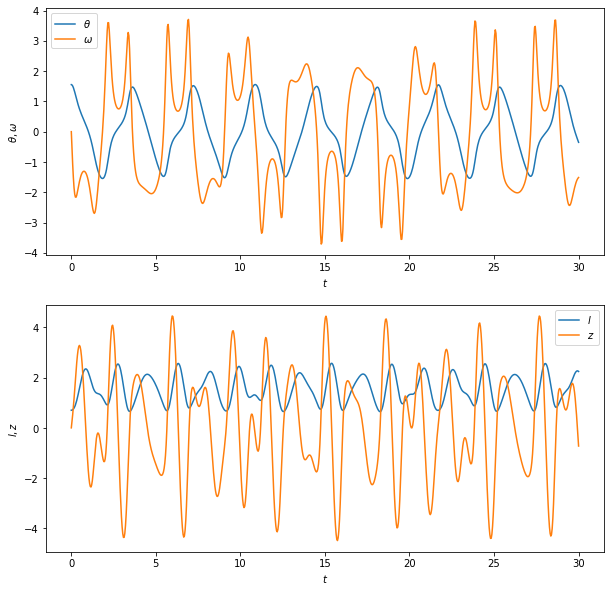

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(t, sol[:, 0], label='$\\theta$')
ax[0].plot(t, sol[:, 1], label='$\\omega$')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$\\theta, \\omega$')
ax[0].legend()
ax[1].plot(t, sol[:, 2], label='$l$')
ax[1].plot(t, sol[:, 3], label='$z$')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$l, z$')
ax[1].legend()
plt.show()

We can plot the phase space of the system:

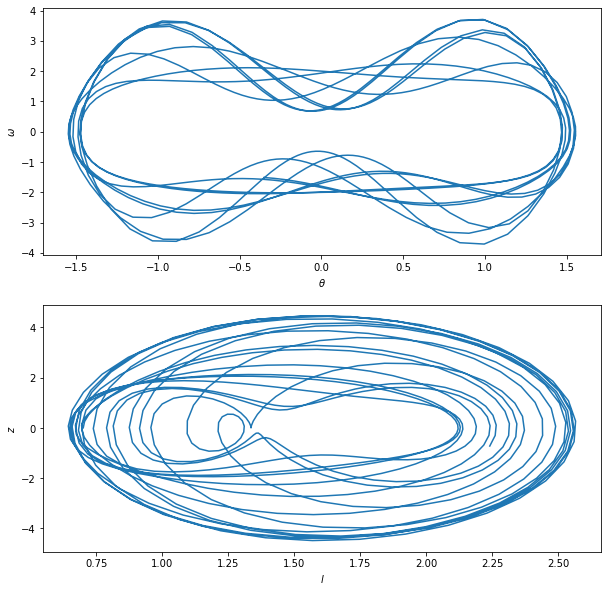

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[0].set_xlabel('$\\theta$')
ax[0].set_ylabel('$\\omega$')
ax[1].plot(sol[:, 2], sol[:, 3])
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$z$')
plt.show()

Now, we can make an animation of the system. But we need a function that returns the position of the mass at each time step, that receives the angle and the length of the pendulum as parameters and returns the position of the mass in the $xy$ plane.

In [16]:
def get_x_y(theta, l):
    x = l * np.sin(theta)
    y = -l * np.cos(theta)
    return x, y

In [17]:
theta, w, x, v = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]

MovieWriter ffmpeg unavailable; using Pillow instead.


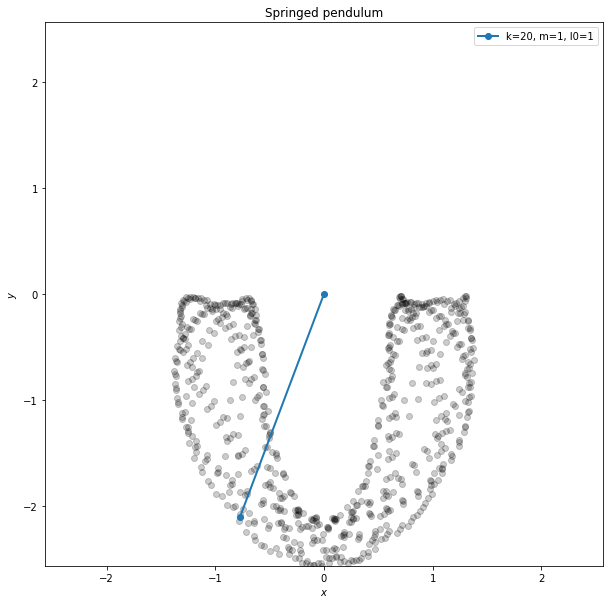

In [18]:
x1, y1 = get_x_y(theta, x)

fig, ax = plt.subplots(figsize=(10, 10))
max_length = max(x)
ax.set_xlim(-max_length, max_length)
ax.set_ylim(-max_length, max_length)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Springed pendulum')
line, = ax.plot([], [], 'o-', lw=2, label=f'k={k}, m={m}, l0={l0}')
path = ax.scatter(x1[0], y1[0], c='k', alpha=0.2)
ax.legend()

def animate(i):
    _x, y = get_x_y(theta[i], x[i])
    line.set_data([0, _x], [0, y])
    path.set_offsets(np.c_[x1[:i], y1[:i]])
    if len(path.get_offsets()) > 100:
        path.set_offsets(path.get_offsets()[1:])
    return line, path

anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=20, blit=True)
anim.save('springed_pendulum.gif', fps=len(t[t<1]))